In [1]:
import pickle
from typing import Dict, Tuple, List
import os
import numpy as np
import json
import torch
import logging
import argparse 
import math
from pprint import pprint
import errno

import torch
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn

from dataset import TrainDataset, BidirectionalOneShotIterator
from evaluation import evaluation
from model import Distmult, Complex, Conve, Transe

In [2]:
def add_arguments():
    parser = argparse.ArgumentParser(description='Link prediction for knowledge graphs')
    
    parser.add_argument('--data', type=str, default='FB15k-237', help='Dataset to use: {FB15k-237, YAGO3-10, WN18RR, umls, nations, kinship}, default: FB15k-237')
    parser.add_argument('--model', type=str, default='conve', help='Choose from: {conve, distmult, complex}')
    parser.add_argument('--add-reciprocals', action='store_true', help='Option to add reciprocal relations')
    
    
    parser.add_argument('--transe-margin', type=float, default=12.0, help='Margin value for TransE scoring function. Default:12.0')
    parser.add_argument('--transe-norm', type=int, default=2, help='P-norm value for TransE scoring function. Default:2')
    
    parser.add_argument('--epochs', type=int, default=400, help='Number of epochs to train (default: 400)')
    parser.add_argument('--lr', type=float, default=0.001, help='Learning rate (default: 0.001)')#maybe 0.1
    parser.add_argument('--lr-decay', type=float, default=0.0, help='Weight decay value to use in the optimizer. Default: 0.0')
    parser.add_argument('--max-norm', action='store_true', help='Option to add unit max norm constraint to entity embeddings')
    
    parser.add_argument('--num-batches', type=int, default=400, help='Number of batches for training (default: 400)') #maybe 200?
    parser.add_argument('--test-batch-size', type=int, default=128, help='Batch size for test split (default: 128)')
    parser.add_argument('--valid-batch-size', type=int, default=128, help='Batch size for valid split (default: 128)')    
    parser.add_argument('--num-workers', type=int, default=4, help='Number of workers to use for the batch loaders on GPU. Default: 4')
    
    parser.add_argument('--embedding-dim', type=int, default=200, help='The embedding dimension (1D). Default: 200')
    
    parser.add_argument('--stack_width', type=int, default=20, help='The first dimension of the reshaped/stacked 2D embedding. Second dimension is inferred. Default: 20')
    #parser.add_argument('--stack_height', type=int, default=10, help='The second dimension of the reshaped/stacked 2D embedding. Default: 10')
    parser.add_argument('--hidden-drop', type=float, default=0.3, help='Dropout for the hidden layer. Default: 0.3.')
    parser.add_argument('--input-drop', type=float, default=0.2, help='Dropout for the input embeddings. Default: 0.2.')
    parser.add_argument('--feat-drop', type=float, default=0.3, help='Dropout for the convolutional features. Default: 0.2.')
    parser.add_argument('-num-filters', default=32,   type=int, help='Number of filters for convolution')
    parser.add_argument('-kernel-size', default=3, type=int, help='Kernel Size for convolution')
    
    parser.add_argument('--use-bias', action='store_true', help='Use a bias in the convolutional layer. Default: True')
    parser.add_argument('--label-smoothing', type=float, default=0.1, help='Label smoothing value to use. Default: 0.1')
    
    
    parser.add_argument('--reg-weight', type=float, default=5e-12, help='Weight for regularization. Default: 5e-12')#maybe 5e-2?
    parser.add_argument('--reg-norm', type=int, default=2, help='Norm for regularization. Default: 3')
    
    parser.add_argument('--resume', action='store_true', help='Restore a saved model.')
    parser.add_argument('--resume-split', type=str, default='test', help='Split to evaluate a restored model')
    parser.add_argument('--seed', type=int, default=17, metavar='S', help='Random seed (default: 17)')
    
    return parser


def generate_dicts(data_path):
    with open (os.path.join(data_path, 'entities_dict.json'), 'r') as f:
        ent_to_id = json.load(f)
    with open (os.path.join(data_path, 'relations_dict.json'), 'r') as f:
        rel_to_id = json.load(f)
    n_ent = len(list(ent_to_id.keys()))
    n_rel = len(list(rel_to_id.keys()))
    
    return n_ent, n_rel, ent_to_id, rel_to_id

import pandas as pd
def load_data(data_path):
    data = {}
    for split in ['train', 'valid', 'test']:
        df = pd.read_csv(os.path.join(data_path, split+'.txt'), sep='\t', header=None, names=None, dtype=int)
        df = df.drop_duplicates()
        data[split] = df.values
        
    return data
    
def add_model(args, n_ent, n_rel):
    if args.add_reciprocals:
        if args.model is None:
            model = Conve(args, n_ent, 2*n_rel)
        elif args.model == 'conve':
            model = Conve(args, n_ent, 2*n_rel)
        elif args.model == 'distmult':
            model = Distmult(args, n_ent, 2*n_rel)
        elif args.model == 'complex':
            model = Complex(args, n_ent, 2*n_rel)
        elif args.model == 'transe':
            model = Transe(args, n_ent, 2*n_rel)
        else:
            logger.info('Unknown model: {0}', args.model)
            raise Exception("Unknown model!")
    else:
        if args.model is None:
            model = Conve(args, n_ent, n_rel)
        elif args.model == 'conve':
            model = Conve(args, n_ent, n_rel)
        elif args.model == 'distmult':
            model = Distmult(args, n_ent, n_rel)
        elif args.model == 'complex':
            model = Complex(args, n_ent, n_rel)
        elif args.model == 'transe':
            model = Transe(args, n_ent, n_rel)
        else:
            logger.info('Unknown model: {0}', args.model)
            raise Exception("Unknown model!")

    #model.to(self.device)
    return model
    

In [3]:
import sys
sys.argv = ['prog.py']

In [4]:
parser = add_arguments()
parser.add_argument('--target-split', type=int, default=1, help='Ranks to use for target set. Values are 1 for ranks <=10; 2 for ranks>10 and ranks<=100. Default: 1')
parser.add_argument('--budget', type=int, default=1, help='Budget for each target triple for each corruption side')
parser.add_argument('--rand-run', type=int, default=1, help='A number assigned to the random run of experiment')




_StoreAction(option_strings=['--rand-run'], dest='rand_run', nargs=None, const=None, default=1, type=<class 'int'>, choices=None, help='A number assigned to the random run of experiment', metavar=None)

In [5]:
args = parser.parse_args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
args.target_split = 1 # which target split to use 
#Values are 1 for ranks <=10; 2 for ranks>10 and ranks<=100.
args.budget = 1 #indicates the num of adversarial edits for each target triple for each corruption side
args.rand_run = 1 #  a number assigned to the random run of the experiment
args.seed = args.seed + (args.rand_run - 1) # default seed is 17

args.model = 'transe'
args.data = 'WN18RR'
if args.data == 'WN18RR':
    if args.model == 'distmult':
        args.lr = 0.01
        args.num_batches = 50
    elif args.model == 'complex':
        args.lr = 0.01
    elif args.model == 'conve':
        args.lr =  0.001
    elif args.model == 'transe':
        args.lr = 0.005 
        args.input_drop = 0.0 
        args.transe_margin = 9.0
        args.num_batches = 1000  
        args.epochs = 100
        args.reg_weight = 1e-12
    else:
        print("New model:{0},{1}. Set hyperparams".format(args.data, args.model))
elif args.data == 'FB15k-237':
    if args.model == 'distmult':
        args.lr = 0.005
        args.input_drop = 0.5
    elif args.model == 'complex':
        args.lr = 0.005
        args.input_drop = 0.5
    elif args.model == 'conve':
        args.lr = 0.001 
        args.hidden_drop = 0.5
    elif args.model == 'transe':
        args.lr = 0.001 
        args.input_drop = 0.0 
        args.transe_margin = 9.0 
        args.num_batches = 800 
        args.epochs = 100
        args.reg_weight = 1e-10
    else:
        print("New model:{0},{1}. Set hyperparams".format(args.data, args.model))
else:
    print("New dataset:{0}. Set hyperparams".format(args.data))

In [7]:
# Fixing random seeds for reproducibility -https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False
np.random.seed(args.seed)
rng = np.random.default_rng(seed=args.seed)


args.epochs = -1 #no training here
model_name = '{0}_{1}_{2}_{3}_{4}'.format(args.model, args.embedding_dim, args.input_drop, args.hidden_drop, args.feat_drop)
model_path = 'saved_models/{0}_{1}.model'.format(args.data, model_name)
#log_path = 'logs/inv_add_1_{0}_{1}_{2}_{3}.log'.format(args.data, model_name, args.num_batches, args.epochs)
    
    
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                        datefmt = '%m/%d/%Y %H:%M:%S',
                        level = logging.INFO
                       )
logger = logging.getLogger(__name__)

In [8]:
logger.info('Loading saved model from {0}'.format(model_path))
state = torch.load(model_path)
model_params = state['state_dict']
params = [(key, value.size(), value.numel()) for key, value in model_params.items()]
for key, size, count in params:
    logger.info('Key:{0}, Size:{1}, Count:{2}'.format(key, size, count))

if args.model == 'complex':
    n_ent = model_params['emb_e_real.weight'].shape[0]
    n_rel = model_params['emb_rel_real.weight'].shape[0]
else:
    n_ent = model_params['emb_e.weight'].shape[0]
    n_rel = model_params['emb_rel.weight'].shape[0]

logger.info('Num entities: {0}; Num relations : {1}'.format(n_ent, n_rel))

model = add_model(args, n_ent, n_rel)
model.to(device)
model.load_state_dict(model_params)

model.eval()

01/22/2021 21:00:47 - INFO - __main__ -   Loading saved model from saved_models/WN18RR_transe_200_0.0_0.3_0.3.model
01/22/2021 21:00:48 - INFO - __main__ -   Key:emb_e.weight, Size:torch.Size([40559, 200]), Count:8111800
01/22/2021 21:00:48 - INFO - __main__ -   Key:emb_rel.weight, Size:torch.Size([11, 200]), Count:2200
01/22/2021 21:00:48 - INFO - __main__ -   Num entities: 40559; Num relations : 11


Transe(
  (emb_e): Embedding(40559, 200)
  (emb_rel): Embedding(11, 200)
  (inp_drop): Dropout(p=0.0, inplace=False)
  (loss): BCEWithLogitsLoss()
)

In [9]:
if args.model == 'complex':
    ent_emb = torch.cat((model.emb_e_real.weight.data, model.emb_e_img.weight.data), dim=-1)
else:
    ent_emb = model.emb_e.weight.data
    
ent_emb = ent_emb.cpu().numpy()

In [12]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import matplotlib.pyplot as plt

In [13]:
kmeans = KMeans(n_clusters=100, n_init=100, max_iter=500, 
                         random_state=0, #batch_size = 100, 
                         init='k-means++', verbose=1
                         #max_no_improvement=20
                        )

In [ ]:
#y_km = kmeans.fit_predict(ent_emb)

In [14]:
# High level grid-search
distortions = []
for i in [5,20,50,100,150,200,250,300, 350, 400, 450, 500]:
    km = KMeans(n_clusters=i, n_init=10, max_iter=500, 
                         random_state=0, #batch_size = 100, 
                         init='k-means++'#, verbose=1
                         #max_no_improvement=20
                        )
    km.fit(ent_emb)
    distortions.append(km.inertia_)

In [ ]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

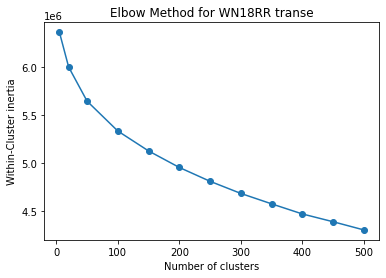

<Figure size 432x288 with 0 Axes>

In [15]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

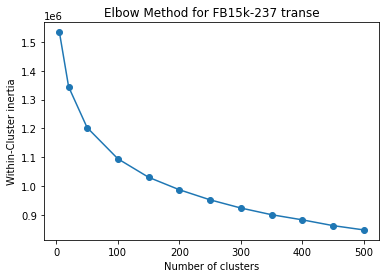

<Figure size 432x288 with 0 Axes>

In [13]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

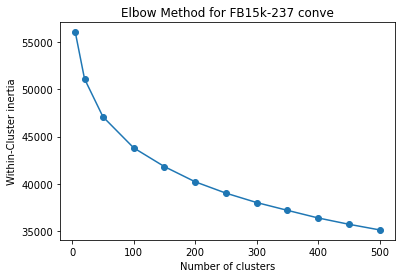

<Figure size 432x288 with 0 Axes>

In [13]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

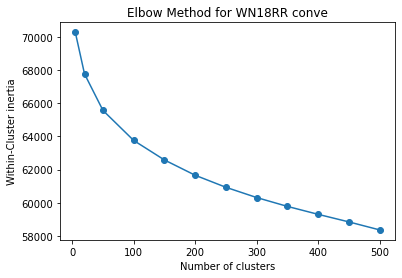

<Figure size 432x288 with 0 Axes>

In [13]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

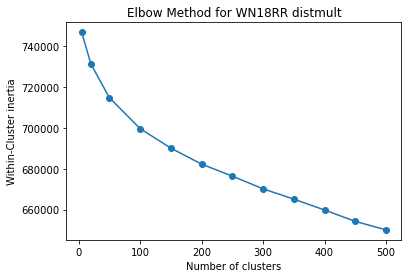

<Figure size 432x288 with 0 Axes>

In [27]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

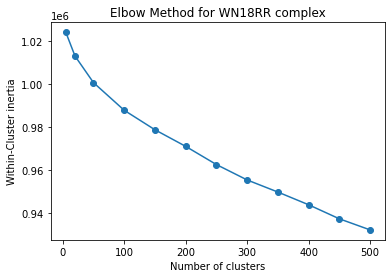

<Figure size 432x288 with 0 Axes>

In [13]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

In [16]:
print(distortions[0], distortions[3], distortions[4]) #distortion for 5, 100, 150

1024189.5 987812.375 978725.875


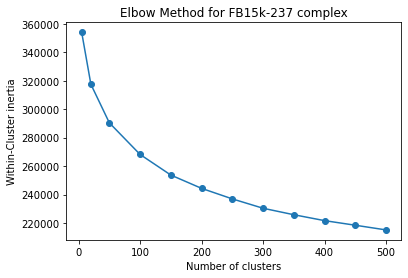

<Figure size 432x288 with 0 Axes>

In [14]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

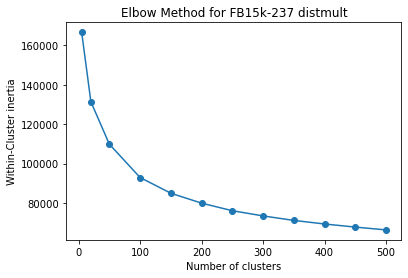

<Figure size 432x288 with 0 Axes>

In [48]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))

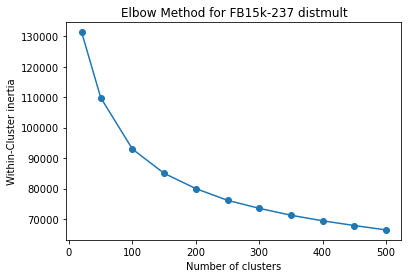

<Figure size 432x288 with 0 Axes>

In [45]:
# plot
plt.plot([5,20,50,100,150,200,250,300, 350, 400, 450, 500], distortions, marker='o')
plt.title('Elbow Method for {0} {1}'.format(args.data, args.model))
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster inertia')
plt.show()
plt.savefig('elbow_plots/{0}_{1}'.format(args.data, args.model))